In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

def generate_sobol_points(n_points, dimensions=2):
    """
    Generate Sobol sequence points using scipy's implementation
    
    Args:
        n_points (int): Number of points to generate
        dimensions (int): Number of dimensions (default: 2)
    
    Returns:
        numpy.ndarray: Array of shape (n_points, dimensions) with Sobol points
    """
    sampler = Sobol(d=dimensions, scramble=False)
    return sampler.random(n_points)

def generate_random_points(n_points, dimensions=2, seed=42):
    """
    Generate pseudo-random points using numpy's random generator
    
    Args:
        n_points (int): Number of points to generate
        dimensions (int): Number of dimensions (default: 2)
        seed (int): Random seed for reproducibility
    
    Returns:
        numpy.ndarray: Array of shape (n_points, dimensions) with random points
    """
    np.random.seed(seed)
    return np.random.random((n_points, dimensions))

def calculate_discrepancy_grid(points, grid_size=10):
    """
    Calculate discrepancy for a grid of rectangular regions
    
    Args:
        points (numpy.ndarray): Array of 2D points
        grid_size (int): Number of grid divisions per dimension
    
    Returns:
        numpy.ndarray: Grid of discrepancy values
    """
    n_points = len(points)
    discrepancy_grid = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Define rectangle [0, x_max) × [0, y_max)
            x_max = (i + 1) / grid_size
            y_max = (j + 1) / grid_size
            
            # Count points in rectangle
            in_rectangle = np.sum((points[:, 0] < x_max) & (points[:, 1] < y_max))
            actual_proportion = in_rectangle / n_points
            expected_proportion = x_max * y_max
            
            discrepancy_grid[j, i] = abs(actual_proportion - expected_proportion)
    
    return discrepancy_grid

def plot_comparison(n_points_list=[64, 256, 1024], figsize=(16, 12)):
    """
    Create comparison plot between random and Sobol sequences
    
    Args:
        n_points_list (list): List of point counts to compare
        figsize (tuple): Figure size (width, height)
    """
    n_comparisons = len(n_points_list)
    
    # Create figure with custom grid layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(n_comparisons, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Color schemes
    random_color = '#FF6B6B'  # Red for random
    sobol_color = '#4ECDC4'   # Teal for Sobol
    
    for idx, n_points in enumerate(n_points_list):
        # Generate points
        random_points = generate_random_points(n_points)
        sobol_points = generate_sobol_points(n_points)
        
        # Calculate discrepancies
        random_discrepancy = calculate_discrepancy_grid(random_points)
        sobol_discrepancy = calculate_discrepancy_grid(sobol_points)
        
        # Plot random points
        ax1 = fig.add_subplot(gs[idx, 0])
        ax1.scatter(random_points[:, 0], random_points[:, 1], 
                   c=random_color, alpha=0.7, s=20, edgecolors='white', linewidth=0.5)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'Random Points\n(n={n_points})', fontsize=12, fontweight='bold')
        if idx == n_comparisons - 1:
            ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        
        # Plot Sobol points
        ax2 = fig.add_subplot(gs[idx, 1])
        ax2.scatter(sobol_points[:, 0], sobol_points[:, 1], 
                   c=sobol_color, alpha=0.7, s=20, edgecolors='white', linewidth=0.5)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_aspect('equal')
        ax2.grid(True, alpha=0.3)
        ax2.set_title(f'Sobol Sequence\n(n={n_points})', fontsize=12, fontweight='bold')
        if idx == n_comparisons - 1:
            ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        
    # Main title
    fig.suptitle('Random vs Sobol Sequences: Distribution Comparison', 
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    return fig

def plot_convergence_analysis(max_points=2048, figsize=(12, 8)):
    """
    Plot convergence analysis showing how discrepancy improves with more points
    
    Args:
        max_points (int): Maximum number of points to analyze
        figsize (tuple): Figure size (width, height)
    """
    # Point counts to analyze (powers of 2 for clean visualization)
    n_points_range = [2**i for i in range(4, int(np.log2(max_points)) + 1)]
    
    random_max_discrepancies = []
    sobol_max_discrepancies = []
    random_avg_discrepancies = []
    sobol_avg_discrepancies = []
    
    for n_points in n_points_range:
        # Generate points
        random_points = generate_random_points(n_points)
        sobol_points = generate_sobol_points(n_points)
        
        # Calculate discrepancy grids
        random_disc = calculate_discrepancy_grid(random_points, grid_size=20)
        sobol_disc = calculate_discrepancy_grid(sobol_points, grid_size=20)
        
        # Store statistics
        random_max_discrepancies.append(np.max(random_disc))
        sobol_max_discrepancies.append(np.max(sobol_disc))
        random_avg_discrepancies.append(np.mean(random_disc))
        sobol_avg_discrepancies.append(np.mean(sobol_disc))
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot maximum discrepancy
    ax1.loglog(n_points_range, random_max_discrepancies, 'o-', 
              color='#FF6B6B', linewidth=2, markersize=8, label='Random (Max)')
    ax1.loglog(n_points_range, sobol_max_discrepancies, 's-', 
              color='#4ECDC4', linewidth=2, markersize=8, label='Sobol (Max)')
    
    # Theoretical convergence lines
    ax1.loglog(n_points_range, [0.5 * (np.log(n)/n)**0.5 for n in n_points_range], 
              '--', color='gray', alpha=0.7, label='O(√(log n)/√n)')
    ax1.loglog(n_points_range, [0.1 * (np.log(n)**2/n) for n in n_points_range], 
              '--', color='darkgreen', alpha=0.7, label='O((log n)²/n)')
    
    ax1.set_xlabel('Number of Points', fontsize=12)
    ax1.set_ylabel('Maximum Discrepancy', fontsize=12)
    ax1.set_title('Maximum Discrepancy vs Number of Points', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot average discrepancy
    ax2.loglog(n_points_range, random_avg_discrepancies, 'o-', 
              color='#FF6B6B', linewidth=2, markersize=8, label='Random (Avg)')
    ax2.loglog(n_points_range, sobol_avg_discrepancies, 's-', 
              color='#4ECDC4', linewidth=2, markersize=8, label='Sobol (Avg)')
    
    ax2.set_xlabel('Number of Points', fontsize=12)
    ax2.set_ylabel('Average Discrepancy', fontsize=12)
    ax2.set_title('Average Discrepancy vs Number of Points', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    return fig

def plot_progressive_filling(n_frames=16, figsize=(15, 10)):
    """
    Create an animation-style plot showing how sequences fill space progressively
    
    Args:
        n_frames (int): Number of frames to show
        figsize (tuple): Figure size (width, height)
    """
    # Generate sequences
    max_points = 2**n_frames
    random_points = generate_random_points(max_points)
    sobol_points = generate_sobol_points(max_points)
    
    # Create subplots
    rows = 4
    cols = n_frames // rows
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(n_frames):
        n_points = 2**(i+1)  # Powers of 2: 2, 4, 8, 16, ...
        
        ax = axes[i]
        
        # Plot both sequences on same subplot
        ax.scatter(random_points[:n_points, 0], random_points[:n_points, 1], 
                  c='#FF6B6B', alpha=0.7, s=30, label='Random', marker='o')
        ax.scatter(sobol_points[:n_points, 0], sobol_points[:n_points, 1], 
                  c='#4ECDC4', alpha=0.7, s=30, label='Sobol', marker='s')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'n = {n_points}', fontsize=12, fontweight='bold')
        
        if i == 0:  # Add legend only to first subplot
            ax.legend(loc='upper right', fontsize=10)
        
        # Add frame border
        for spine in ax.spines.values():
            spine.set_linewidth(2)
    
    fig.suptitle('Progressive Space Filling: Random vs Sobol Sequences', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

Generating Sobol vs Random sequence comparisons...
Creating main comparison plot...


/tmp/ipykernel_36/2940751250.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


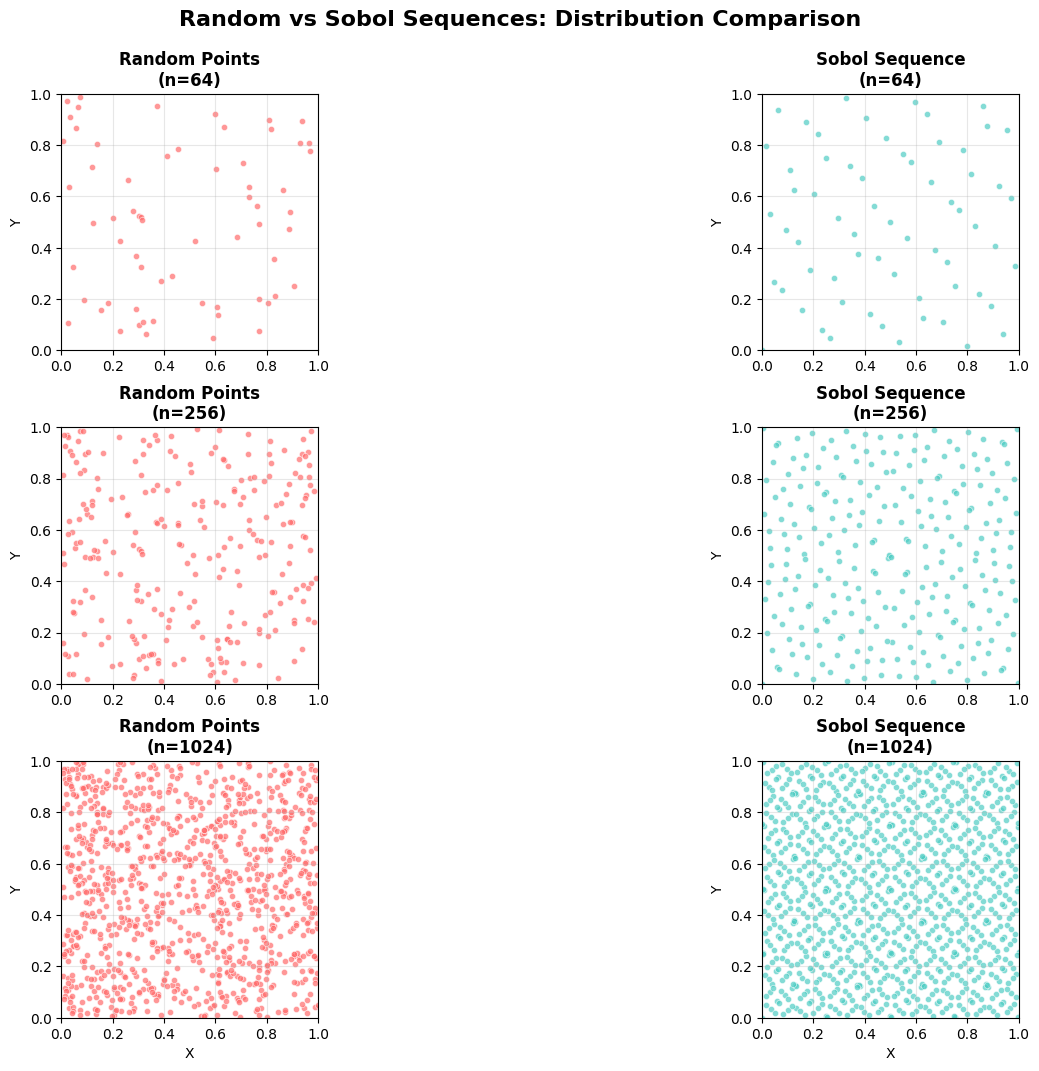

Creating convergence analysis...


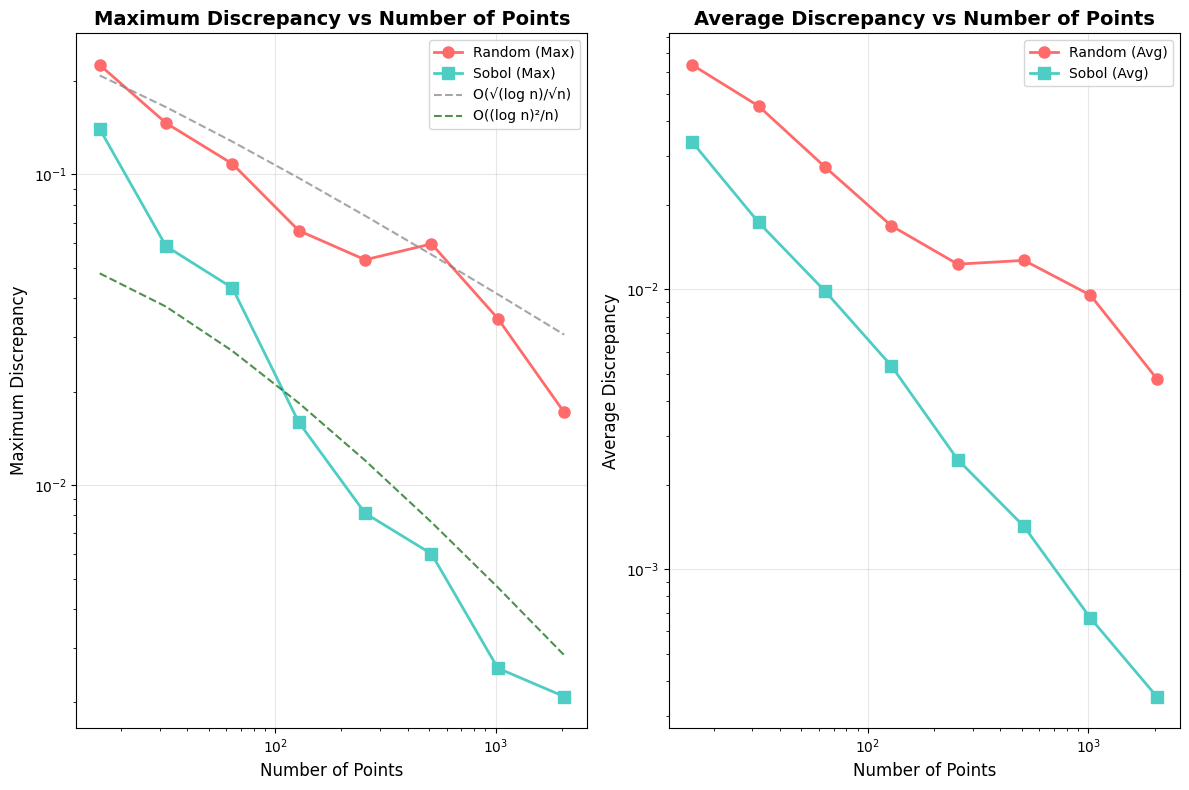

Creating progressive filling visualization...


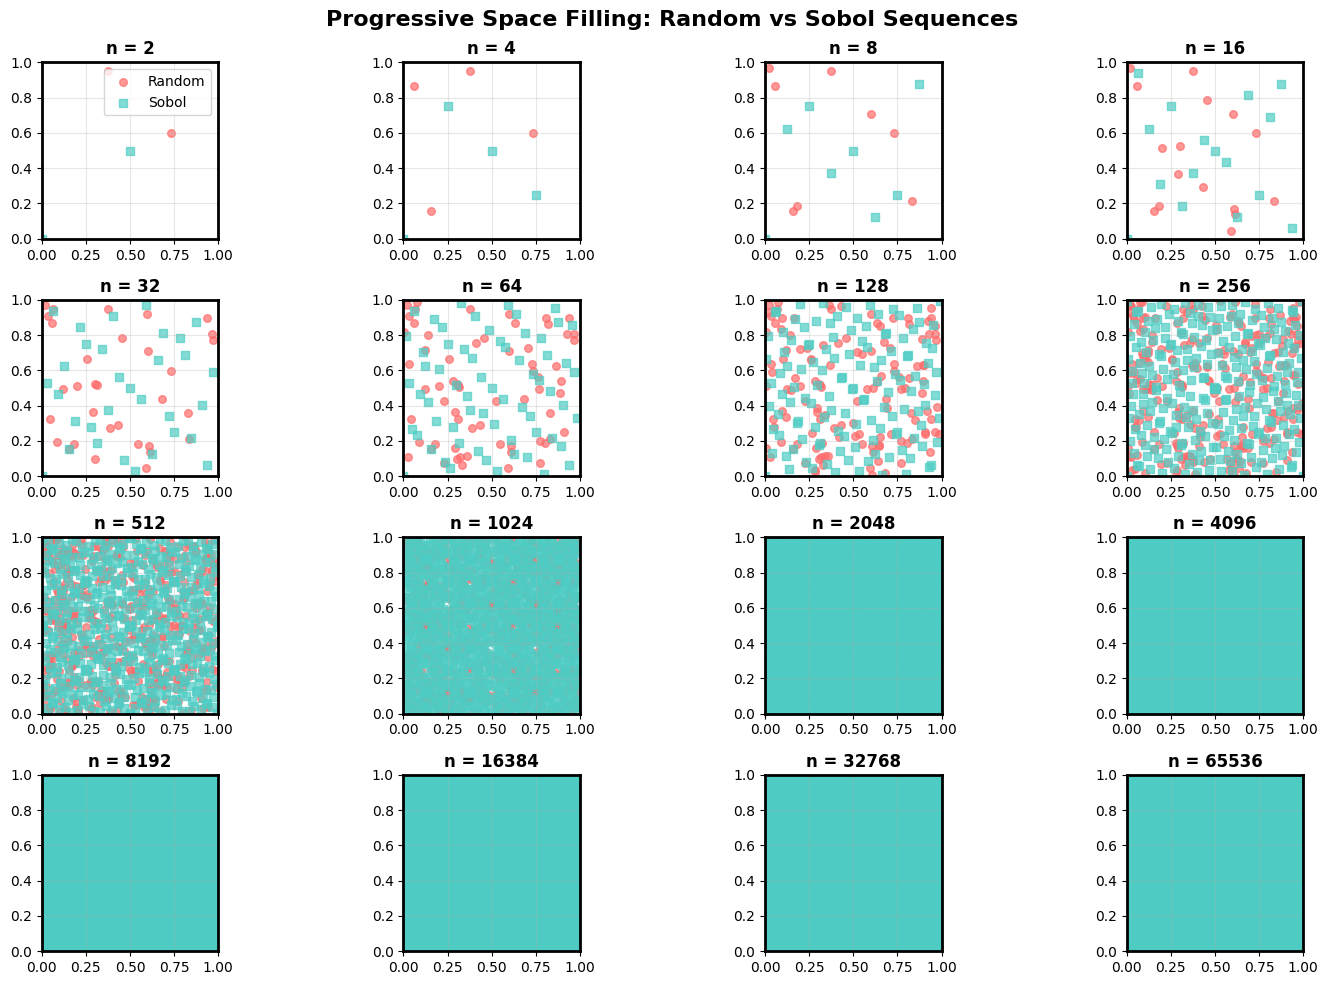

All plots generated successfully!
Plots saved as PNG files!


In [12]:

# Main execution
if __name__ == "__main__":
    # Set style
    plt.style.use('default')
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.size'] = 10
    
    print("Generating Sobol vs Random sequence comparisons...")
    
    # 1. Main comparison plot
    print("Creating main comparison plot...")
    fig1 = plot_comparison(n_points_list=[64, 256, 1024])
    plt.show()
    
    # 2. Convergence analysis
    print("Creating convergence analysis...")
    fig2 = plot_convergence_analysis(max_points=2048)
    plt.show()
    
    # 3. Progressive filling animation-style plot
    print("Creating progressive filling visualization...")
    fig3 = plot_progressive_filling(n_frames=16)
    plt.show()
    
    print("All plots generated successfully!")
    
    ## Optional: Save plots
    # save_plots = input("\nSave plots to files? (y/n): ").lower().strip() == 'y'
    save_plots = True
    if save_plots:
        fig1.savefig('/kaggle/working/sobol_vs_random_comparison.png', bbox_inches='tight', dpi=300)
        fig2.savefig('/kaggle/working/sobol_convergence_analysis.png', bbox_inches='tight', dpi=300)
        fig3.savefig('/kaggle/working/sobol_progressive_filling.png', bbox_inches='tight', dpi=300)
        print("Plots saved as PNG files!")